<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Authors:_ Joseph Nelson (DC), Boom Devahastin Na Ayudhya (NYC), Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [ ]:
#!pip3 install scipy statsmodels --upgrade

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv', infer_datetime_format=True, parse_dates=[2])
data.set_index('Date', inplace=True)
data.sort_index()
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [5]:
data.info() # no null values

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [10]:
display(data['Store'].value_counts())
display(data['Dept'].value_counts())
display(data['IsHoliday'].value_counts())

13    10474
10    10315
4     10272
1     10244
2     10238
24    10228
27    10225
34    10224
20    10214
6     10211
32    10202
19    10148
31    10142
28    10113
41    10088
11    10062
23    10050
14    10040
40    10017
15     9901
8      9895
39     9878
17     9864
18     9859
26     9854
25     9804
7      9762
12     9705
22     9688
45     9637
21     9582
35     9528
29     9455
16     9443
3      9036
5      8999
9      8867
38     7362
37     7206
44     7169
30     7156
42     6953
43     6751
33     6487
36     6222
Name: Store, dtype: int64

1     6435
16    6435
92    6435
38    6435
40    6435
      ... 
78     235
77     150
65     143
39      16
43      12
Name: Dept, Length: 81, dtype: int64

False    391909
True      29661
Name: IsHoliday, dtype: int64

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [24]:
Weekly_Sales = data.loc[data['Store']==1, ['Weekly_Sales']].resample('7D').sum()

In [25]:
Weekly_Sales.head(3)

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17


In [26]:
Weekly_Sales.shape

(143, 1)

#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

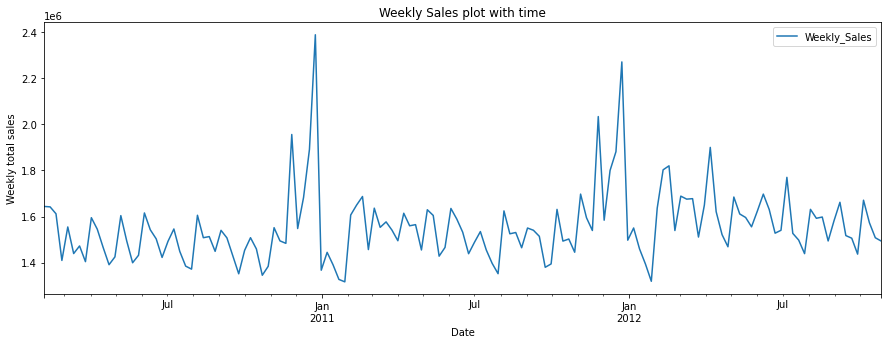

In [31]:
Weekly_Sales.plot(kind='line', figsize=(15,5),
                 ylabel='Weekly total sales', 
                 title='Weekly Sales plot with time');

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

In [34]:
# four week rolling mean
monthly_roll_mean = Weekly_Sales.rolling(4).mean()
# quarterly rolling mean
quartly_roll_mean = Weekly_Sales.rolling(12).mean()
# annually rolling mean
annual_roll_mean = Weekly_Sales.rolling(52).mean()

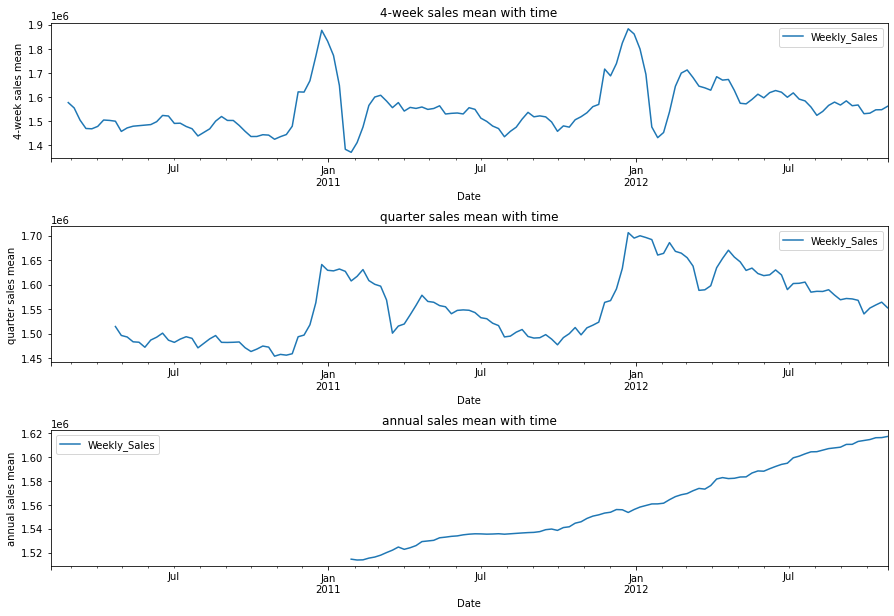

In [43]:
# plot rolling means
fig, axes = plt.subplots(3, 1, figsize=(15,10))

monthly_roll_mean.plot(kind='line', figsize=(15,10),
           ylabel='4-week sales mean', 
           title='4-week sales mean with time', ax=axes[0])

quartly_roll_mean.plot(kind='line', figsize=(15,10),
           ylabel='quarter sales mean', 
           title='quarter sales mean with time', ax=axes[1])

annual_roll_mean.plot(kind='line', figsize=(15,10),
           ylabel='annual sales mean', 
           title='annual sales mean with time', ax=axes[2]);

plt.subplots_adjust(hspace=0.5) # adjust space between subplots

**2c. What can you say about trends in the data based on the rolling mean plot above?**

**Answer:** There is a seasonality of sales within each year. But the general trend is that sales are increasing year-on-year. Sales tend to peak at the end of each year (holiday season). 

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [44]:
# create new columns for the 3 lag intervals
# 1-week lag
Weekly_Sales['lag_1w'] = Weekly_Sales['Weekly_Sales'].shift(1)
# 2-weeks lag
Weekly_Sales['lag_2w'] = Weekly_Sales['Weekly_Sales'].shift(2)
# 1 year lag (52 weeks)
Weekly_Sales['lag_1y'] = Weekly_Sales['Weekly_Sales'].shift(52)

In [45]:
Weekly_Sales.head(3)

,Weekly_Sales,lag_1w,lag_2w,lag_1y
Date,,,,
2010-02-05,1643690.90,NaN,NaN,NaN
2010-02-12,1641957.44,1643690.90,NaN,NaN
2010-02-19,1611968.17,1641957.44,1643690.9,NaN


In [46]:
# corr
Weekly_Sales.corr()

,Weekly_Sales,lag_1w,lag_2w,lag_1y
Weekly_Sales,1.000000,0.302158,0.127413,0.895376
lag_1w,0.302158,1.000000,0.301574,0.194373
lag_2w,0.127413,0.301574,1.000000,0.052809
lag_1y,0.895376,0.194373,0.052809,1.000000


**3b. What can you say about the series based on these autocorrelations?**

**Answer:** The series is better for long-term prediction rather than short-term prediction

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

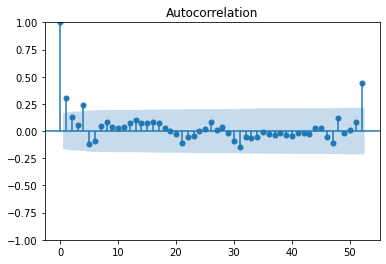

In [49]:
plot_acf(Weekly_Sales['Weekly_Sales'], lags=52);

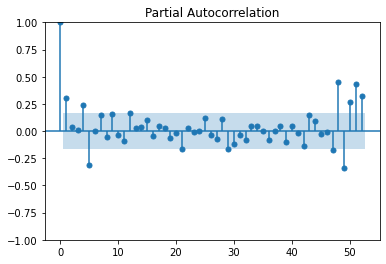

In [50]:
plot_pacf(Weekly_Sales['Weekly_Sales'], lags=52);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

**Answer:** The graphs confirm that there is high correlation between current sales, sales in 1 week and sales in 4 weeks. 

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

**Answer:** Since both ACF and PACF graphs have a similar pattern (no tail-off), I would choose ARMA / ARIMA for model. AR or MA would not be suitable.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [59]:
Weekly_Sales.shape

(143, 4)

In [51]:
# What index gives us our 75th percentile of rows?
Weekly_Sales.shape[0] * (3 / 4)

107.25

In [52]:
train = Weekly_Sales.iloc[0:107]

test = Weekly_Sales.iloc[107:]

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. In each section, we will add additional ARIMA parameters in an effort to improve our modeling. Note that sometimes the model you attempt is not effective or the best -- try the BONUS sections below to see other approaches to modeling this dataset!

- Note that this is the same thing as an `ARIMA(1,0,0)` model.
- Pass in the Weekly Sales as an `ndarray`, not a `Series`.
- Pass in the training index using the ARIMA `dates` parameter.

**6a. Instantiate and fit an `AR(1)` model.**

In [57]:
# Instantiate an AR(1) model on training data.
# time periods 0 through 106.
ar1 = ARIMA(endog = train['Weekly_Sales'].to_numpy(),
            order = (1, 0, 0), # (p, d, q)
            dates = train.index)

# Fit AR(1) model.
model = ar1.fit()

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [58]:
from sklearn.metrics import mean_squared_error

In [62]:
# Generate predictions based on train set.
# Start at time period 0 and end at 106.
train_preds = model.predict(start=0, end=106)

# Generate predictions based on test set.
# Start at time period 107 and end at 142.
test_preds = model.predict(start=107, end=142)

# Evaluate predictions.
print('train MSE:', mean_squared_error(train['Weekly_Sales'], train_preds))
print('test MSE:', mean_squared_error(test['Weekly_Sales'], test_preds))

train MSE: 25903503058.390297
test MSE: 11108604491.056726


**6c. How effective do you think this `AR(1)` model is?**

**Answer:** Not effective

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [68]:
train_predictions = [x for x in model.predict(start=0, end=106)]
test_predictions = [x for x in model.predict(start=107, end=142)]

# calculate residuals
train_residuals = [train['Weekly_Sales'].values[i]-train_predictions[i] for i in range(len(train_predictions))]
test_residuals = [test['Weekly_Sales'].values[i]-test_predictions[i] for i in range(len(test_predictions))]

# join residuals into continuous list
residuals = train_residuals + test_residuals

In [69]:
residuals = pd.DataFrame(residuals)

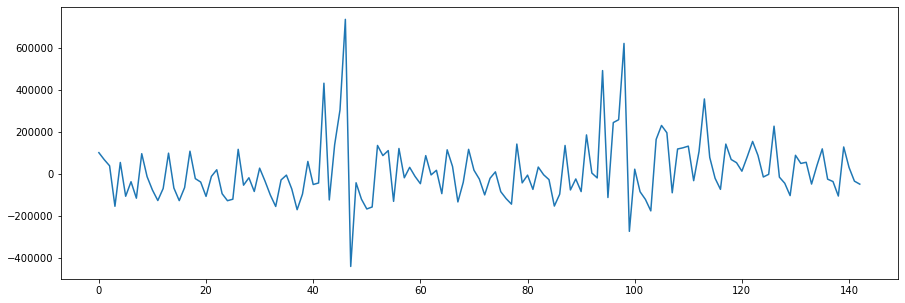

In [74]:
residuals.plot(figsize=(15,5), legend=False);

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

**Answer:** Model is not good at predicting sales spikes at year-ends.

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [75]:
# Instantiate an AR(2) model on training data.
# time periods 0 through 106.
ar2 = ARIMA(endog = train['Weekly_Sales'].to_numpy(),
            order = (2, 0, 0), # (p, d, q)
            dates = train.index)

# Fit AR(1) model.
model = ar2.fit()

In [76]:
# Generate predictions based on train set.
# Start at time period 0 and end at 106.
train_preds = model.predict(start=0, end=106)

# Generate predictions based on test set.
# Start at time period 107 and end at 142.
test_preds = model.predict(start=107, end=142)

# Evaluate predictions.
print('train MSE:', mean_squared_error(train['Weekly_Sales'], train_preds))
print('test MSE:', mean_squared_error(test['Weekly_Sales'], test_preds))

train MSE: 25814337771.79711
test MSE: 10932762249.965187


In [77]:
train_predictions = [x for x in model.predict(start=0, end=106)]
test_predictions = [x for x in model.predict(start=107, end=142)]

# calculate residuals
train_residuals = [train['Weekly_Sales'].values[i]-train_predictions[i] for i in range(len(train_predictions))]
test_residuals = [test['Weekly_Sales'].values[i]-test_predictions[i] for i in range(len(test_predictions))]

# join residuals into continuous list
residuals = train_residuals + test_residuals

In [78]:
residuals = pd.DataFrame(residuals)

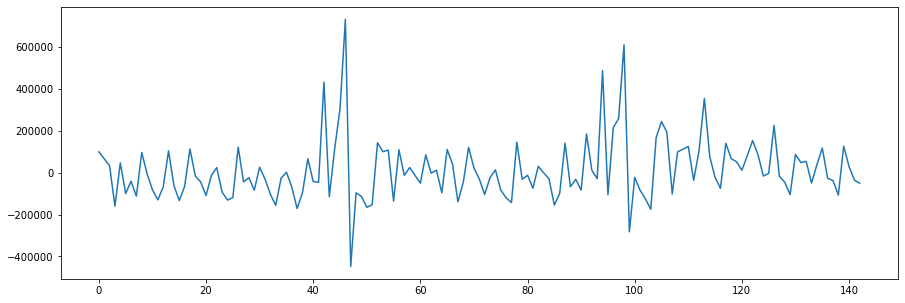

In [79]:
residuals.plot(figsize=(15,5), legend=False);

**8b. How did your results change?**

**Answer:** No significant change in results

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [80]:
# Instantiate an ARMA(2,2) model on training data.
# time periods 0 through 106.
ar22 = ARIMA(endog = train['Weekly_Sales'].to_numpy(),
            order = (2, 0, 2), # (p, d, q)
            dates = train.index)

# Fit AR(2) model.
model = ar22.fit()

In [81]:
# Generate predictions based on train set.
# Start at time period 0 and end at 106.
train_preds = model.predict(start=0, end=106)

# Generate predictions based on test set.
# Start at time period 107 and end at 142.
test_preds = model.predict(start=107, end=142)

# Evaluate predictions.
print('train MSE:', mean_squared_error(train['Weekly_Sales'], train_preds))
print('test MSE:', mean_squared_error(test['Weekly_Sales'], test_preds))

train MSE: 21601543600.36403
test MSE: 11047421701.489294


In [82]:
train_predictions = [x for x in model.predict(start=0, end=106)]
test_predictions = [x for x in model.predict(start=107, end=142)]

# calculate residuals
train_residuals = [train['Weekly_Sales'].values[i]-train_predictions[i] for i in range(len(train_predictions))]
test_residuals = [test['Weekly_Sales'].values[i]-test_predictions[i] for i in range(len(test_predictions))]

# join residuals into continuous list
residuals = train_residuals + test_residuals

In [83]:
residuals = pd.DataFrame(residuals)

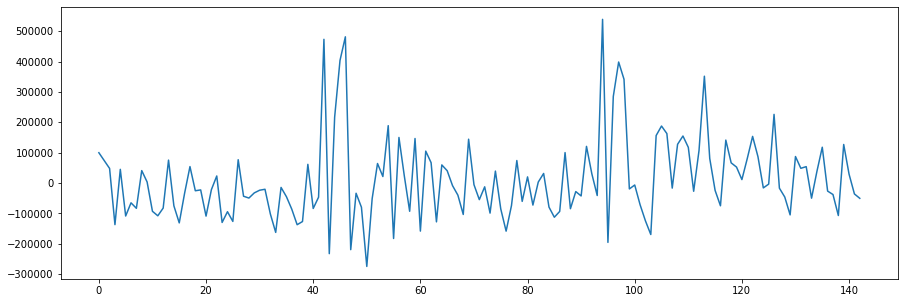

In [84]:
residuals.plot(figsize=(15,5), legend=False);

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



**Answer:** Magnitude of errors is reduced by comparing the y-axis of previous residual plots

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [85]:
# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Execute test on training data.
interpret_dftest(adfuller(train['Weekly_Sales']))

Test Statistic   -4.688682
p-value           0.000088
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

**Answer:** Because $p$ is less than our reasonable choices for $\alpha$, we have enough evidence to reject the null hypothesis and we accept that our time series is stationary.

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [86]:
# 1-period diff
Weekly_Sales['diff_1'] = Weekly_Sales['Weekly_Sales'].diff(periods=1)
# 2-period diff
Weekly_Sales['diff_2'] = Weekly_Sales['Weekly_Sales'].diff(periods=2)
# 3-period diff
Weekly_Sales['diff_3'] = Weekly_Sales['Weekly_Sales'].diff(periods=3)
# 4-period diff
Weekly_Sales['diff_4'] = Weekly_Sales['Weekly_Sales'].diff(periods=4)

In [87]:
Weekly_Sales.head(5)

,Weekly_Sales,lag_1w,lag_2w,lag_1y,diff_1,diff_2,diff_3,diff_4
Date,,,,,,,,
2010-02-05,1643690.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-12,1641957.44,1643690.90,NaN,NaN,-1733.46,NaN,NaN,NaN
2010-02-19,1611968.17,1641957.44,1643690.90,NaN,-29989.27,-31722.73,NaN,NaN
2010-02-26,1409727.59,1611968.17,1641957.44,NaN,-202240.58,-232229.85,-233963.31,NaN
2010-03-05,1554806.68,1409727.59,1611968.17,NaN,145079.09,-57161.49,-87150.76,-88884.22


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [93]:
Weekly_Sales.fillna(0, inplace=True)

In [94]:
# Execute adf test on diff_1
print('--- adf test result of diff_1 column ---')
display(interpret_dftest(adfuller(Weekly_Sales['diff_1'])))
# Execute adf test on diff_2
print('--- adf test result of diff_2 column ---')
display(interpret_dftest(adfuller(Weekly_Sales['diff_2'])))
# Execute adf test on diff_3
print('--- adf test result of diff_3 column ---')
display(interpret_dftest(adfuller(Weekly_Sales['diff_3'])))
# Execute adf test on diff_4
print('--- adf test result of diff_4 column ---')
display(interpret_dftest(adfuller(Weekly_Sales['diff_4'])))

--- adf test result of diff_1 column ---


Test Statistic   -7.350325e+00
p-value           1.009959e-10
dtype: float64

--- adf test result of diff_2 column ---


Test Statistic   -6.151778e+00
p-value           7.531969e-08
dtype: float64

--- adf test result of diff_3 column ---


Test Statistic   -5.136571
p-value           0.000012
dtype: float64

--- adf test result of diff_4 column ---


Test Statistic   -6.944478e+00
p-value           1.005416e-09
dtype: float64

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

**Answer:** All the columns seem meaningful to have differenced the data

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

**Answer:** ARIMA model is a good starting point, but it is not the best choice for this data that has seasonality despite being able to manipulate data to be stationary. 

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [100]:
# Instantiate an ARIMA(2,2,2) model on training data.
# time periods 0 through 106.
ar222 = ARIMA(endog = train['Weekly_Sales'].to_numpy(),
            order = (2, 1, 2), # (p, d, q)
            dates = train.index)

# Fit AR(2) model.
model = ar222.fit()

In [101]:
# Generate predictions based on train set.
# Start at time period 0 and end at 106.
train_preds = model.predict(start=0, end=106)

# Generate predictions based on test set.
# Start at time period 107 and end at 142.
test_preds = model.predict(start=107, end=142)

# Evaluate predictions.
print('train MSE:', mean_squared_error(train['Weekly_Sales'], train_preds))
print('test MSE:', mean_squared_error(test['Weekly_Sales'], test_preds))

train MSE: 55427941709.6053
test MSE: 11861625648.365807


In [102]:
train_predictions = [x for x in model.predict(start=0, end=106)]
test_predictions = [x for x in model.predict(start=107, end=142)]

# calculate residuals
train_residuals = [train['Weekly_Sales'].values[i]-train_predictions[i] for i in range(len(train_predictions))]
test_residuals = [test['Weekly_Sales'].values[i]-test_predictions[i] for i in range(len(test_predictions))]

# join residuals into continuous list
residuals = train_residuals + test_residuals

In [103]:
residuals = pd.DataFrame(residuals)

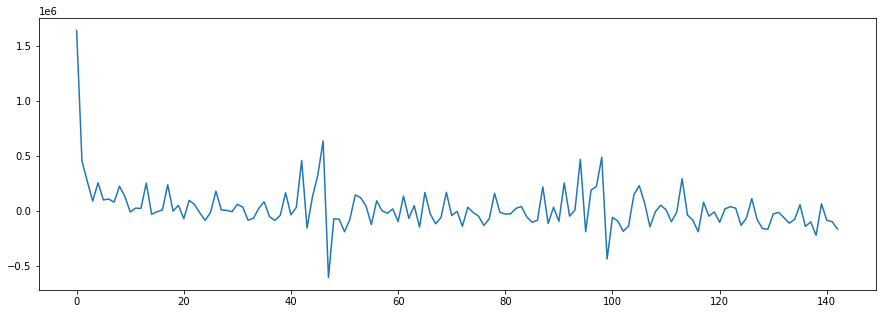

In [104]:
residuals.plot(figsize=(15,5), legend=False);

**11b. Interpret the results from the last answer.**


**Answer:** With differencing of order 1, the smaller residuals are reduced, but the peak residuals are larger. 

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [111]:
sarima = SARIMAX(endog = train['Weekly_Sales'],
                 order = (2, 0, 2),              # (p, d, q)
                 seasonal_order = (2, 0, 2, 5))

# Fit SARIMA model.
model = sarima.fit()

In [112]:
# Generate predictions based on train set.
# Start at time period 0 and end at 106.
train_preds = model.predict(start=0, end=106)

# Generate predictions based on test set.
# Start at time period 107 and end at 142.
test_preds = model.predict(start=107, end=142)

# Evaluate predictions.
print('train MSE:', mean_squared_error(train['Weekly_Sales'], train_preds))
print('test MSE:', mean_squared_error(test['Weekly_Sales'], test_preds))

train MSE: 50201791772.40517
test MSE: 13017208183.215166


In [113]:
train_predictions = [x for x in model.predict(start=0, end=106)]
test_predictions = [x for x in model.predict(start=107, end=142)]

# calculate residuals
train_residuals = [train['Weekly_Sales'].values[i]-train_predictions[i] for i in range(len(train_predictions))]
test_residuals = [test['Weekly_Sales'].values[i]-test_predictions[i] for i in range(len(test_predictions))]

# join residuals into continuous list
residuals = train_residuals + test_residuals

In [114]:
residuals = pd.DataFrame(residuals)

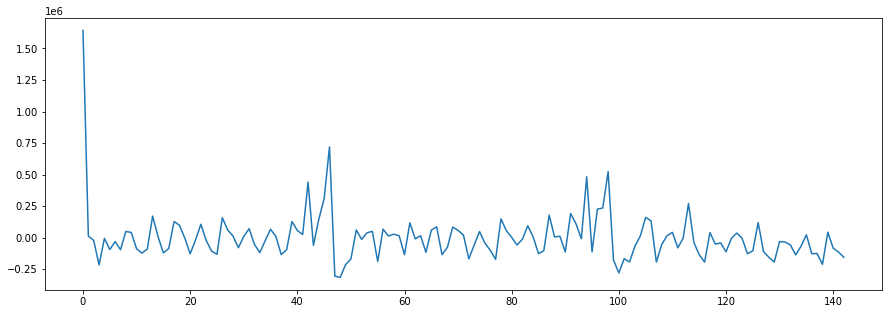

In [115]:
residuals.plot(figsize=(15,5), legend=False);

**12b. How did your best SARIMAX model perform?**

**Answer:** Slightly better than ARIMA model, more optimistic model. errors tend to more positive than negative values. Magnitude of errors with positive value comparable to ARIMA model.

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: 

**13c. How might you improve it?**

Answer:

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: